In [79]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler

### imports for neural network

In [80]:
import tensorflow as tf
from tensorflow.keras.layers import Input, LSTM, Dense, Dropout, Flatten
from tensorflow.keras.losses import mean_absolute_percentage_error, mean_squared_error, mean_absolute_error
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.activations import tanh, relu

## Write a function to convert time series into train and test sets
We are going to resample our dataset every 1 day   => 1 sample per day.
We are going to use 30 days to predict the next 7 days' usage
Therefore, we are setting the following 2 global variables:

WINDOW_SIZE = 30

HORIZON = 7

(These can be changed as per requirement)

In [81]:
WINDOW_SIZE = 30
HORIZON = 7
def prepare_training_and_test_sets(df, window_size = WINDOW_SIZE, horizon= HORIZON, test_size = 0.2):
    '''
        Pass the time series, window_size, horizon, and test_size
        If none passed, then the following default values are taken:
        window_size = 42
        horizon = 6
        test_size = 0.2 (20%)

    '''

    X, y = [], []

    for i in range(len(df)-window_size-horizon+1):

        window = df.iloc[i:(i+window_size)].values

        X.append(window)
        y.append(df.iloc[(i+window_size):(i+window_size+horizon)])

    X = np.array(X)
    y = np.array(y)

    split_idx = int(len(X) * (1-test_size))

    X_train = X[:split_idx]
    y_train = y[:split_idx]


    X_test = X[split_idx:]
    y_test = y[split_idx:]

    return X_train, y_train, X_test, y_test

# Read data from csv

In [82]:
df = pd.read_csv('merged_data.csv' ,usecols=['TIME', 'NAME', 'BIKE STANDS','AVAILABLE BIKE STANDS'], parse_dates=['TIME'])

In [27]:
df.head(5), df.tail(5)

(                 TIME           NAME  BIKE STANDS  AVAILABLE BIKE STANDS
 0 2018-08-01 12:30:02  CLARENDON ROW           31                      1
 1 2018-08-01 12:35:02  CLARENDON ROW           31                      2
 2 2018-08-01 12:40:02  CLARENDON ROW           31                      2
 3 2018-08-01 12:45:02  CLARENDON ROW           31                      2
 4 2018-08-01 12:50:02  CLARENDON ROW           31                      3,
                         TIME               NAME  BIKE STANDS  \
 37986396 2021-04-01 23:35:03  HANOVER QUAY EAST           40   
 37986397 2021-04-01 23:40:02  HANOVER QUAY EAST           40   
 37986398 2021-04-01 23:45:02  HANOVER QUAY EAST           40   
 37986399 2021-04-01 23:50:02  HANOVER QUAY EAST           40   
 37986400 2021-04-01 23:55:02  HANOVER QUAY EAST           40   
 
           AVAILABLE BIKE STANDS  
 37986396                     40  
 37986397                     40  
 37986398                     40  
 37986399              

In [83]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 37986401 entries, 0 to 37986400
Data columns (total 4 columns):
 #   Column                 Dtype         
---  ------                 -----         
 0   TIME                   datetime64[ns]
 1   NAME                   object        
 2   BIKE STANDS            int64         
 3   AVAILABLE BIKE STANDS  int64         
dtypes: datetime64[ns](1), int64(2), object(1)
memory usage: 1.1+ GB


# Create a mapping to map the bike stands to Dublin zones

In [84]:
zone_mapping = {'CLARENDON ROW':'Dublin_2','BLESSINGTON STREET': 'Dublin_7',
		  'BOLTON STREET': 'Dublin_1',
		  'GREEK STREET': 'Dublin_7',
		  'CHARLEMONT PLACE': 'Dublin_2',
		  'CHRISTCHURCH PLACE': 'Dublin_8',
		  'HIGH STREET': 'Dublin_8',
		  'CUSTOM HOUSE QUAY': 'Dublin_1',
		  'EXCHEQUER STREET': 'Dublin_2',
		  'DAME STREET': 'Dublin_2',
		  'EARLSFORT TERRACE': 'Dublin_2',
		  'ECCLES STREET': 'Dublin_7',
		  'FITZWILLIAM SQUARE WEST': 'Dublin_2',
		  'FOWNES STREET UPPER': 'Dublin_2',
		  'HARDWICKE STREET': 'Dublin_1',
		  'GEORGES QUAY': 'Dublin_2',
		  'GOLDEN LANE': 'Dublin_8',
		  'GRANTHAM STREET': 'Dublin_8',
		  'HERBERT PLACE': 'Dublin_2',
		  'LEINSTER STREET SOUTH': 'Dublin_2',
		  'TOWNSEND STREET': 'Dublin_2',
		  'CUSTOM HOUSE': 'Dublin_1',
		  'CATHAL BRUGHA STREET': 'Dublin_1',
		  'MERRION SQUARE EAST': 'Dublin_2',
		  'MERRION SQUARE WEST': 'Dublin_2',
		  'MOLESWORTH STREET': 'Dublin_2',
		  'MOUNTJOY SQUARE WEST': 'Dublin_1',
		  'ORMOND QUAY UPPER': 'Dublin_7',
		  'PARNELL SQUARE NORTH': 'Dublin_1',
		  'PARNELL STREET': 'Dublin_1',
		  'PEARSE STREET': 'Dublin_2',
		  "PRINCES STREET / O'CONNELL STREET": 'Dublin_2',
		  'PORTOBELLO HARBOUR': 'Dublin_8',
		  'SMITHFIELD': 'Dublin_7',
		  "ST. STEPHEN'S GREEN EAST": 'Dublin_2',
		  "ST. STEPHEN'S GREEN SOUTH": 'Dublin_2',
		  'TALBOT STREET': 'Dublin_1',
		  'WILTON TERRACE': 'Dublin_2',
		  'JERVIS STREET': 'Dublin_1',
		  'HARCOURT TERRACE': 'Dublin_2',
		  'SMITHFIELD NORTH': 'Dublin_7',
		  'PORTOBELLO ROAD': 'Dublin_8',
		  'UPPER SHERRARD STREET': 'Dublin_1',
		  'DEVERELL PLACE': 'Dublin_1',
		  'HERBERT STREET': 'Dublin_2',
		  'EXCISE WALK': 'Dublin_1',
		  'GUILD STREET': 'Dublin_1',
		  'GEORGES LANE': 'Dublin_7',
		  'YORK STREET WEST': 'Dublin_2',
		  'YORK STREET EAST': 'Dublin_2',
		  'NEWMAN HOUSE': 'Dublin_2',
		  'CLONMEL STREET': 'Dublin_2',
		  'HATCH STREET': 'Dublin_2',
		  'MOUNT STREET LOWER': 'Dublin_2',
		  'GRATTAN STREET': 'Dublin_2',
		  "SIR PATRICK DUN'S": 'Dublin_2',
		  'DENMARK STREET GREAT': 'Dublin_1',
		  'NORTH CIRCULAR ROAD': 'Dublin_1',
		  'HARDWICKE PLACE': 'Dublin_1',
		  'LIME STREET': 'Dublin_2',
		  'FENIAN STREET': 'Dublin_2',
		  'SANDWITH STREET': 'Dublin_2',
		  'CONVENTION CENTRE': 'Dublin_1',
		  'NEW CENTRAL BANK': 'Dublin_1',
		  'THE POINT': 'Dublin_2',
		  'HANOVER QUAY': 'Dublin_4',
		  'GRAND CANAL DOCK': 'Dublin_8',
		  'KEVIN STREET': 'Dublin_8',
		  'JOHN STREET WEST': 'Dublin_8',
		  'FRANCIS STREET': 'Dublin_8',
		  'OLIVER BOND STREET': 'Dublin_8',
		  'JAMES STREET': 'Dublin_2',
		  'MARKET STREET SOUTH': 'Dublin_1',
		  'WOLFE TONE STREET': 'Dublin_1',
		  'MATER HOSPITAL': 'Dublin_7',
		  'ECCLES STREET EAST': 'Dublin_8',
		  'ST JAMES HOSPITAL (LUAS)': 'Dublin_8',
		  'ST. JAMES HOSPITAL (CENTRAL)': 'Dublin_8',
		  'MOUNT BROWN': 'Dublin_8',
		  'EMMET ROAD': 'Dublin_8',
		  'BROOKFIELD ROAD': 'Dublin_8',
		  'ROTHE ABBEY': 'Dublin_8',
		  'PARKGATE STREET': 'Dublin_7',
		  'COLLINS BARRACKS MUSEUM': 'Dublin_7',
		  'BLACKHALL PLACE': 'Dublin_2',
		  'FITZWILLIAM SQUARE EAST': 'Dublin_2',
		  'BENSON STREET': 'Dublin_4',
		  'SOUTH DOCK ROAD': 'Dublin_7',
		  'HEUSTON BRIDGE (NORTH)': 'Dublin_8',
		  'HEUSTON STATION (CENTRAL)': 'Dublin_8',
		  'HEUSTON STATION (CAR PARK)': 'Dublin_4',
		  'ROYAL HOSPITAL': 'Dublin_8',
		  'KILMAINHAM LANE': 'Dublin_8',
		  'KILMAINHAM GAOL': 'Dublin_2',
		  'FREDERICK STREET SOUTH': 'Dublin_2',
		  'CITY QUAY': 'Dublin_8',
		  'HEUSTON BRIDGE (SOUTH)': 'Dublin_7',
		  'KING STREET NORTH': 'Dublin_7',
		  'WESTERN WAY': 'Dublin_7',
		  'GRANGEGORMAN LOWER (SOUTH)': 'Dublin_7',
		  'GRANGEGORMAN LOWER (CENTRAL)': 'Dublin_7',
		  'GRANGEGORMAN LOWER (NORTH)': 'Dublin_7',
		  'RATHDOWN ROAD': 'Dublin_7',
		  'CHARLEVILLE ROAD': 'Dublin_7',
		  'AVONDALE ROAD': 'Dublin_1',
		  'BUCKINGHAM STREET LOWER': 'Dublin_7',
		  'PHIBSBOROUGH ROAD': 'Dublin_1',
		  'MOUNTJOY SQUARE EAST': 'Dublin_1',
		  "NORTH CIRCULAR ROAD (O'CONNELL'S)": 'Dublin_2',
		  'MERRION SQUARE SOUTH': 'Dublin_2',
		  'WILTON TERRACE (PARK)': 'Dublin_1',
		  'KILLARNEY STREET': 'Dublin_1','BUCKINGHAM STREET LOWER':'Dublin_1', 'HANOVER QUAY EAST':'Dublin_2', 'BROADSTONE':'Dublin_7',
        'ORIEL STREET TEST TERMINAL':'Dublin_1','STRAND STREET GREAT':'Dublin_1', 'BARROW STREET':'Dublin_4'}

In [85]:
df['ZONE'] = df['NAME'].map(zone_mapping)
df.head(), df.tail()

(                 TIME           NAME  BIKE STANDS  AVAILABLE BIKE STANDS  \
 0 2018-08-01 12:30:02  CLARENDON ROW           31                      1   
 1 2018-08-01 12:35:02  CLARENDON ROW           31                      2   
 2 2018-08-01 12:40:02  CLARENDON ROW           31                      2   
 3 2018-08-01 12:45:02  CLARENDON ROW           31                      2   
 4 2018-08-01 12:50:02  CLARENDON ROW           31                      3   
 
        ZONE  
 0  Dublin_2  
 1  Dublin_2  
 2  Dublin_2  
 3  Dublin_2  
 4  Dublin_2  ,
                         TIME               NAME  BIKE STANDS  \
 37986396 2021-04-01 23:35:03  HANOVER QUAY EAST           40   
 37986397 2021-04-01 23:40:02  HANOVER QUAY EAST           40   
 37986398 2021-04-01 23:45:02  HANOVER QUAY EAST           40   
 37986399 2021-04-01 23:50:02  HANOVER QUAY EAST           40   
 37986400 2021-04-01 23:55:02  HANOVER QUAY EAST           40   
 
           AVAILABLE BIKE STANDS      ZONE  
 3798639

# Split the dataset into zones

In [86]:
zone_wise_data = df.groupby(by = 'ZONE')

Dublin_1 = zone_wise_data.get_group(name = 'Dublin_1')
Dublin_2 = zone_wise_data.get_group(name = 'Dublin_2')
Dublin_4 = zone_wise_data.get_group(name = 'Dublin_4')
Dublin_7 = zone_wise_data.get_group(name = 'Dublin_7')
Dublin_8 = zone_wise_data.get_group(name = 'Dublin_8')

In [87]:
len(Dublin_1), len(Dublin_2), len(Dublin_4), len(Dublin_7) , len(Dublin_8)

(9157192, 13411936, 1125673, 6506275, 7785325)

## Rerun the below steps with different zones

# Construct the target variable and delete all unnecessary columns

In [88]:
Dublin_2['UTILIZATION'] =  Dublin_2['AVAILABLE BIKE STANDS'] / Dublin_2['BIKE STANDS']

/var/folders/9d/jx81c37d3sq3_nxqpsv0gfc80000gn/T/ipykernel_11231/504739657.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Dublin_2['UTILIZATION'] =  Dublin_2['AVAILABLE BIKE STANDS'] / Dublin_2['BIKE STANDS']


In [89]:
columns_to_drop = ['NAME', 'ZONE', 'BIKE STANDS', 'AVAILABLE BIKE STANDS']
Dublin_2.drop(columns= columns_to_drop, inplace= True)

Dublin_2.head()

/var/folders/9d/jx81c37d3sq3_nxqpsv0gfc80000gn/T/ipykernel_11231/1569797210.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Dublin_2.drop(columns= columns_to_drop, inplace= True)


,TIME,UTILIZATION
0,2018-08-01 12:30:02,0.032258
1,2018-08-01 12:35:02,0.064516
2,2018-08-01 12:40:02,0.064516
3,2018-08-01 12:45:02,0.064516
4,2018-08-01 12:50:02,0.096774


## Resample on daily basis

In [90]:
Dublin_2 = Dublin_2.resample(rule = '1D', on = 'TIME').mean()

In [91]:
Dublin_2.head(10)

,UTILIZATION
TIME,
2018-08-01,0.638202
2018-08-02,0.651591
2018-08-03,0.671549
2018-08-04,0.670721
2018-08-05,0.571346
2018-08-06,0.507161
2018-08-07,0.574964
2018-08-08,0.658644
2018-08-09,0.656310


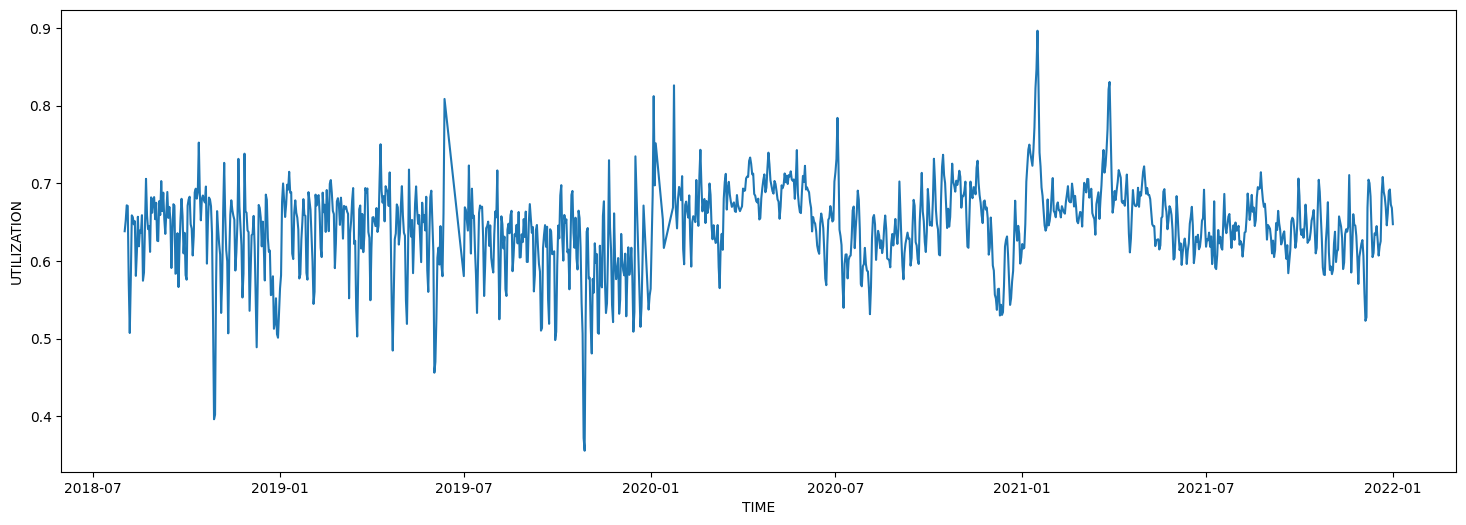

In [92]:
plt.figure(figsize = (18, 6))
sns.lineplot(data = Dublin_2, x = Dublin_2.index, y = Dublin_2['UTILIZATION'])
plt.show()

# Convert the time series into training and test set (we have already defined a function at the top for this purpose

In [160]:
testing_end_date = '2020-02-28'
D2_set=Dublin_2[Dublin_2.index <=testing_end_date]
D2_predset=Dublin_2[Dublin_2.index >testing_end_date]

In [102]:
D2_set.head()

,UTILIZATION
TIME,
2018-08-01,0.638202
2018-08-02,0.651591
2018-08-03,0.671549
2018-08-04,0.670721
2018-08-05,0.571346


Fill the missing values

In [108]:
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(strategy= 'mean')
D2_set['UTILIZATION'] = imputer.fit_transform(np.reshape(D2_set['UTILIZATION'], newshape=(-1,1)))
D2_set.isnull().sum()

/var/folders/9d/jx81c37d3sq3_nxqpsv0gfc80000gn/T/ipykernel_11231/2447111878.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  D2_set['UTILIZATION'] = imputer.fit_transform(np.reshape(D2_set['UTILIZATION'], newshape=(-1,1)))


UTILIZATION    0
dtype: int64

In [109]:
X_train, y_train, X_test, y_test = prepare_training_and_test_sets(D2_set)

In [110]:
len(X_train), len(y_train), len(X_test), len(y_test)

(432, 432, 109, 109)

In [111]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((432, 30, 1), (432, 7, 1), (109, 30, 1), (109, 7, 1))

In [114]:
X_train.min(), X_test.min(), X_train.max(), X_test.max()

(0.35556290867752977,
 0.35556290867752977,
 0.8085340577531376,
 0.826026034172082)

# Model with horizon of 7

In [180]:
input = Input(shape=(WINDOW_SIZE,1))
lstm1 = LSTM(64, activation='tanh', return_sequences=True)(input)
lstm2 = LSTM(64, activation='tanh')(lstm1)
dense1 = Dense(32, activation= 'relu')(lstm2)
output = Dense(HORIZON)(dense1)

model_6 = Model(input, output)

model_6.compile(loss = 'mse', optimizer = 'adam', metrics = ['mae'])
model_6.fit(X_train, y_train, epochs=50, batch_size=32, verbose=1)

Epoch 1/50


ValueError: in user code:

    File "/Users/samarthagrawal/Downloads/ML/senv/lib/python3.11/site-packages/keras/src/engine/training.py", line 1401, in train_function  *
        return step_function(self, iterator)
    File "/Users/samarthagrawal/Downloads/ML/senv/lib/python3.11/site-packages/keras/src/engine/training.py", line 1384, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/Users/samarthagrawal/Downloads/ML/senv/lib/python3.11/site-packages/keras/src/engine/training.py", line 1373, in run_step  **
        outputs = model.train_step(data)
    File "/Users/samarthagrawal/Downloads/ML/senv/lib/python3.11/site-packages/keras/src/engine/training.py", line 1155, in train_step
        return self.compute_metrics(x, y, y_pred, sample_weight)
    File "/Users/samarthagrawal/Downloads/ML/senv/lib/python3.11/site-packages/keras/src/engine/training.py", line 1249, in compute_metrics
        self.compiled_metrics.update_state(y, y_pred, sample_weight)
    File "/Users/samarthagrawal/Downloads/ML/senv/lib/python3.11/site-packages/keras/src/engine/compile_utils.py", line 620, in update_state
        metric_obj.update_state(y_t, y_p, sample_weight=mask)
    File "/Users/samarthagrawal/Downloads/ML/senv/lib/python3.11/site-packages/keras/src/utils/metrics_utils.py", line 77, in decorated
        result = update_state_fn(*args, **kwargs)
    File "/Users/samarthagrawal/Downloads/ML/senv/lib/python3.11/site-packages/keras/src/metrics/base_metric.py", line 140, in update_state_fn
        return ag_update_state(*args, **kwargs)
    File "/Users/samarthagrawal/Downloads/ML/senv/lib/python3.11/site-packages/keras/src/metrics/base_metric.py", line 723, in update_state  **
        matches = ag_fn(y_true, y_pred, **self._fn_kwargs)
    File "/Users/samarthagrawal/Downloads/ML/senv/lib/python3.11/site-packages/keras/src/metrics/accuracy_metrics.py", line 459, in sparse_categorical_accuracy
        matches = metrics_utils.sparse_categorical_matches(y_true, y_pred)
    File "/Users/samarthagrawal/Downloads/ML/senv/lib/python3.11/site-packages/keras/src/utils/metrics_utils.py", line 961, in sparse_categorical_matches
        y_true = tf.squeeze(y_true, [-1])

    ValueError: Can not squeeze dim[1], expected a dimension of 1, got 7 for '{{node Squeeze}} = Squeeze[T=DT_FLOAT, squeeze_dims=[-1]](remove_squeezable_dimensions/Squeeze)' with input shapes: [?,7].


In [178]:
model_6.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 30, 1)]           0         
                                                                 
 lstm_4 (LSTM)               (None, 30, 64)            16896     
                                                                 
 lstm_5 (LSTM)               (None, 64)                33024     
                                                                 
 dense_4 (Dense)             (None, 32)                2080      
                                                                 
 dense_5 (Dense)             (None, 7)                 231       
                                                                 
Total params: 52231 (204.03 KB)
Trainable params: 52231 (204.03 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [164]:
predicted_values = []

# function to create test samples using model predictions

In [144]:
def next_sample(df):
    preds = model_6.predict(df.reshape(1, WINDOW_SIZE))
    
    df[:HORIZON] = preds
    predicted_values.append(preds)
    new_test_sample = np.roll(df, - HORIZON)
    return new_test_sample

In [148]:
predicted_values

[array([[0.65176845, 0.63978255, 0.6381167 , 0.6518648 , 0.63804066,
         0.65453553, 0.65257096]], dtype=float32)]

Make predictions for 1.5 years which means making predictions 78 times (because each prediction returns forecast for 7 days)

In [165]:
sample = np.squeeze(X_test[-1])
for i in range(97):
    new_sample = next_sample(sample)
    sample = new_sample
    

1/1 [==============================] - 0s 9ms/step


In [166]:
predicted_values[0]

array([[0.65158355, 0.63986444, 0.6385039 , 0.6521476 , 0.6376071 ,
        0.6543609 , 0.6524313 ]], dtype=float32)

In [167]:
predicted_usage = np.array(predicted_values)

In [168]:
predicted_usage.shape

(97, 1, 7)

In [169]:
predicted_usage = predicted_usage.flatten()

In [170]:
predicted_usage.shape

(679,)

In [171]:
D2_predset['PREDICTED_USAGE'] = predicted_usage[:-6]

/var/folders/9d/jx81c37d3sq3_nxqpsv0gfc80000gn/T/ipykernel_11231/1705354068.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  D2_predset['PREDICTED_USAGE'] = predicted_usage[:-6]


In [173]:
D2_predset['UTILIZATION'].mean(), D2_predset['PREDICTED_USAGE'].mean()

(0.6551250166737533, 0.6413783)

<Axes: xlabel='TIME'>

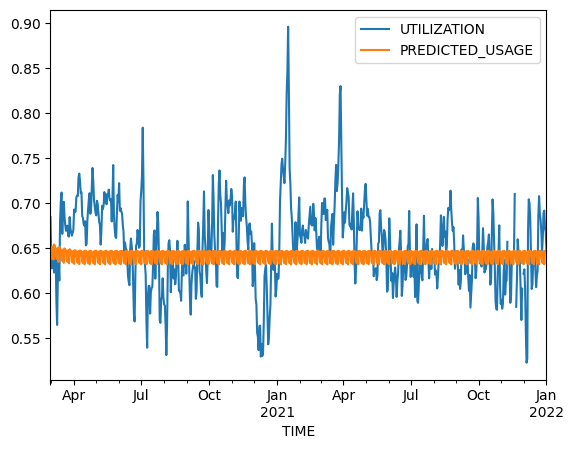

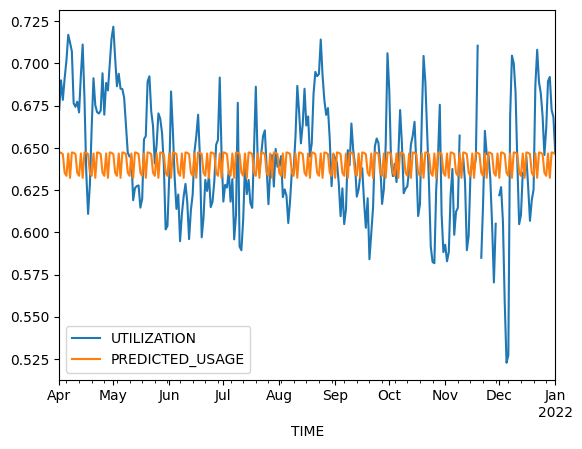

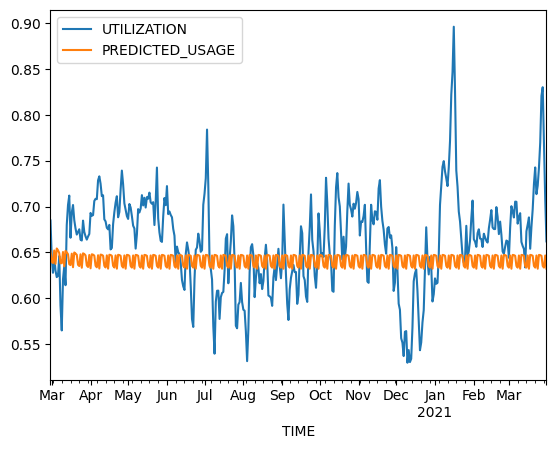

In [177]:
D2_predset.plot(kind = 'line')
post_pandemic_date='2021-04-01'
pandemic_set=D2_predset[D2_predset.index<post_pandemic_date]
post_pandemic_set=D2_predset[D2_predset.index>=post_pandemic_date]
post_pandemic_set.plot(kind='line')
pandemic_set.plot(kind='line')